# Grabbing processed data

In [1]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
# need to grab mean and std for each column so that we can normalize the df and apply clustering

joined = spark.read.parquet('./FINAL_processed_data')
print(joined.printSchema())

columns = joined.columns



# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season' and column!= 'record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))

# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season' and column!='record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))




root
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- Season: long (nullable = true)
 |-- origin_prcp: long (nullable = true)
 |-- origin_tmax: long (nullable = true)
 |-- origin_tmin: long (nullable = true)
 |-- origin_awnd: long (nullable = true)
 |-- dest_prcp: long (nullable = true)
 |-- dest_tmax: long (nullable = true)
 |-- dest_tmin: long (nullable = true)
 |-- dest_awnd: long (nullable = true)
 |-- record_id: long (nullable = true)

None
Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857406145, origin_long_mean=-92.27161607308254, dest_lat_mean=37.09915724198568, des

## Plotting Locations of Clusters from season =0 (winter) and k=8 and 4 representatives per cluster

In [2]:
season = 0
k = 8
num_reps = 4
fraction = 0.2

In [3]:
if season !=4:
    clusters = spark.read.parquet('./CURE_Clusters/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
else:
    # then we want all data
    clusters = spark.read.parquet('./CURE_Clusters/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
print(clusters.printSchema())

root
 |-- representative:1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:3: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:4: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [4]:
# selecting origin latitude and longitude of clusters
# these are the fifth and sixth elements of the records

# locations holds DENORMALIZED (latitude, longitude, cluster_id) tuples for representatives in each cluster
locations = []
clusters = clusters.collect()
for i,cluster in enumerate(clusters):
    for representative in cluster:
        denormalized_lat = (representative[4] * stats['origin_lat_stddev']) + stats['origin_lat_mean']
        denormalized_long = (representative[5] * stats['origin_long_stddev']) + stats['origin_long_mean']
        locations.append((denormalized_lat,denormalized_long,i))
print(locations)

[(35.67640819053541, -104.67049792150463, 0), (34.71452663853541, -93.44501392150464, 0), (39.566404414535405, -108.10184547350462, 0), (34.71452663853541, -93.44501392150464, 0), (34.523009668191676, -80.1473462777124, 1), (44.675070332191666, -114.19294161371238, 1), (32.18847033219167, -92.38671938971238, 1), (35.358121444191674, -110.84140113371238, 1), (40.51952633290459, -77.62088829211184, 2), (42.53248588490459, -95.39028295611182, 2), (40.51952633290459, -77.62088829211184, 2), (27.610853220904595, -98.94026006811183, 2), (35.23680192323164, -122.18076404087108, 3), (22.402265259231648, -150.9754826808711, 3), (38.93098837123164, -94.96112825687109, 3), (28.97426792323165, -103.4133791448711, 3), (45.0406052523026, -62.67386881267559, 4), (41.1887185883026, -66.36891814067559, 4), (40.1989654763026, -72.75742791667558, 4), (50.445793028302596, -101.18639084467557, 4), (30.469630603160695, -105.30509425154659, 5), (16.597208379160698, -85.1626053635466, 5), (26.420075043160693,

In [10]:
# getting packages we need
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install shapely

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


     latitude   longitude  cluster_id                     geometry
0   35.676408 -104.670498           0  POINT (-104.67050 35.67641)
1   34.714527  -93.445014           0   POINT (-93.44501 34.71453)
2   39.566404 -108.101845           0  POINT (-108.10185 39.56640)
3   34.714527  -93.445014           0   POINT (-93.44501 34.71453)
4   34.523010  -80.147346           1   POINT (-80.14735 34.52301)
5   44.675070 -114.192942           1  POINT (-114.19294 44.67507)
6   32.188470  -92.386719           1   POINT (-92.38672 32.18847)
7   35.358121 -110.841401           1  POINT (-110.84140 35.35812)
8   40.519526  -77.620888           2   POINT (-77.62089 40.51953)
9   42.532486  -95.390283           2   POINT (-95.39028 42.53249)
10  40.519526  -77.620888           2   POINT (-77.62089 40.51953)
11  27.610853  -98.940260           2   POINT (-98.94026 27.61085)
12  35.236802 -122.180764           3  POINT (-122.18076 35.23680)
13  22.402265 -150.975483           3  POINT (-150.97548 22.40

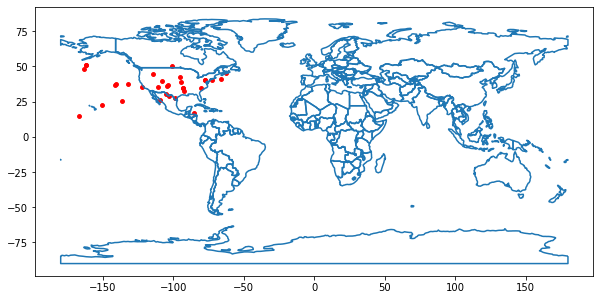

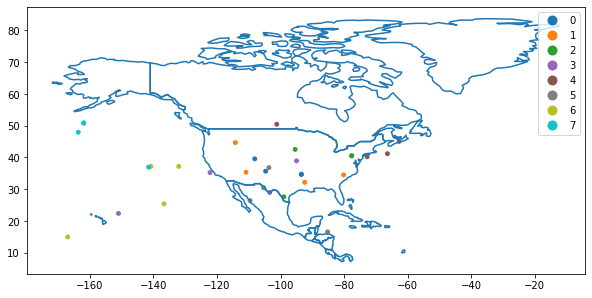

In [19]:
# plotting these latitude longitude values on a map with shapely and geopandas
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame



df = pd.DataFrame(locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);

## For each cluster, what is the delay distribution of elements within the cluster?

## For each cluster, what is the weather distribution of elements within the cluster?